In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def move(x, y, theta, vx, yawrate):
    dt = 0.1
    x = vx*dt*np.cos(theta)+x
    y = vx*dt*np.sin(theta)+y
    theta = theta + yawrate*dt

    return x,y,theta

In [3]:

option = "no"

if option == "circle":
    x = 0
    y = 0
    theta = 0
    vx = 30
    yawrate = vx / 50 

    xTrace = [x]
    yTrace = [y]
    thetaTrace = [theta]
    for i in range(150):
        x,y,theta = move(x,y,theta, vx, yawrate)
        xTrace.append(x)
        yTrace.append(y)
        thetaTrace.append(theta)
else:
    xTrace = np.linspace(0, 20,20)
    yTrace = 0.1*(xTrace -10)**2
    thetaTrace = 0.2*xTrace - 2


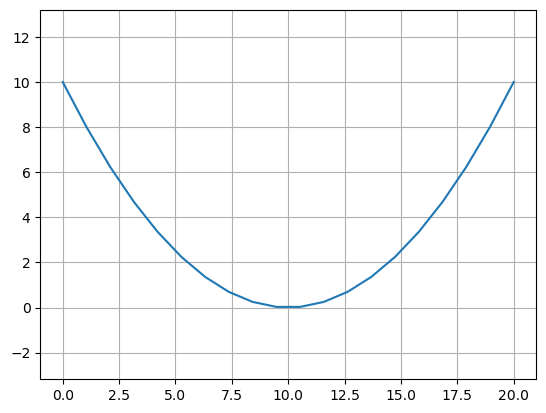

In [4]:
plt.plot(xTrace,yTrace)
plt.axis('equal')
plt.grid()

In [5]:
t = np.linspace(0,1,100)

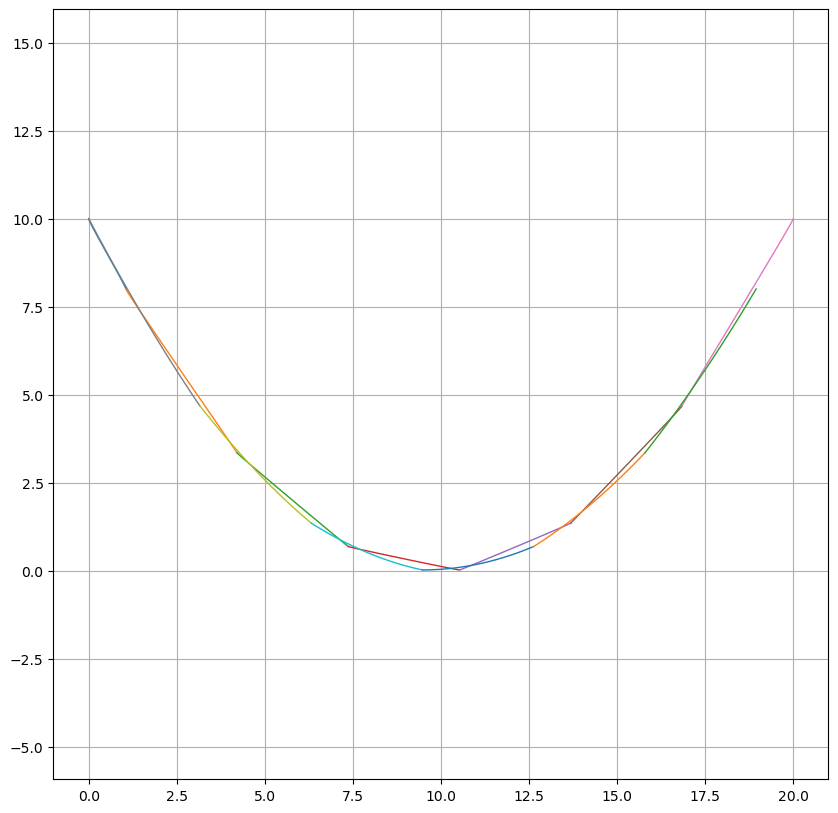

In [6]:
# 에르미트 스플라인
def hermite_basis(t):
    h0 = 2*t**3 - 3*t**2 + 1
    h1 = -2*t**3 + 3*t**2
    h2 = t**3 - 2*t**2 + t
    h3 = t**3 - t**2
    return h0, h1, h2, h3

plt.figure(figsize = (10,10))
P0 = np.array([xTrace[0], yTrace[0]])
T0 = np.array([np.cos(thetaTrace[0]), np.sin(thetaTrace[0])])* 0.2

h0, h1, h2, h3, = hermite_basis(t)
for i in range(1, len(xTrace), 3):

        P1 = np.array([xTrace[i], yTrace[i]])
        T1 = np.array([np.cos(thetaTrace[i]), np.sin(thetaTrace[i])]) *0.2

        #plt.scatter(P0[0], P0[1])
        #plt.scatter(P1[0], P1[1])

        x1 = h0*P0[0] + h1*P1[0] + h2*T0[0] + h3*T1[0]
        y1 = h0*P0[1] + h1*P1[1] + h2*T0[1] + h3*T1[1]

        plt.plot(x1, y1, label='Hermite Curve', linewidth=1)
        #plt.quiver(P1[0], P1[1], T1[0], T1[1], color='blue', scale=50)

        P0 = P1
        T0 = T1

plt.grid()
plt.axis('equal')


# 베지에 스플라인
# bezier-spline
def bezier_spline_basis(i, t):
    if i == 0:
        return (1 - t)**3
    elif i == 1:
        return 3 * t * (1-t)**2
    elif i == 2:
        return 3 * (1-t) * t**2
    elif i == 3:
        return t**3

# Compute B-spline curve
def bezier_spline_curve(t, P):
    return (
        bezier_spline_basis(0, t)  * P[0]
        + bezier_spline_basis(1, t)* P[1]
        + bezier_spline_basis(2, t)* P[2]
        + bezier_spline_basis(3, t)* P[3]
    )

xTrace_Copy = xTrace.copy()
yTrace_Copy = yTrace.copy()

for idx in range(0, len(xTrace_Copy), 3):
    if (idx > len(xTrace_Copy)-4):
        break

    Points = np.array([Point for Point in zip(xTrace_Copy[0:4], yTrace_Copy[0:4])])
    #plt.scatter(Points[:,0], Points[:,1])

    xTrace_Copy = np.roll(xTrace_Copy, -3)
    yTrace_Copy = np.roll(yTrace_Copy, -3)

    curve_points = np.array([bezier_spline_curve(ti, Points) for ti in t])
    plt.plot(curve_points[:, 0], curve_points[:, 1], linewidth = 1)

plt.axis('equal')

plt.show()



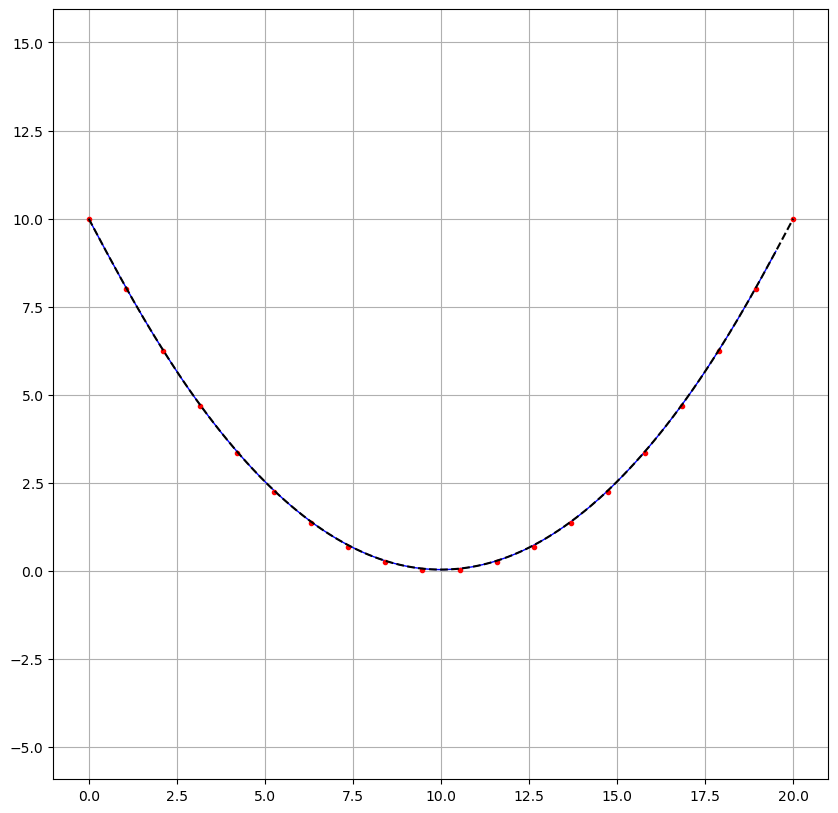

In [7]:
# cox-de boor 점화식에 의한 B-SPLINE
Points = np.array([Point for Point in zip(xTrace, yTrace)])
n = len(Points) - 1
k = 3  # Degree of the B-spline

def b_spline_basis(i, k, t, knots):
    # cox-de boor
    if k == 0:
        return 1.0 if knots[i] <= t < knots[i+1] else 0.0
    else:
        d1 = knots[i+k] - knots[i]
        d2 = knots[i+k+1] - knots[i+1]
        term1 = 0 if d1 == 0 else (t - knots[i]) / d1 * b_spline_basis(i, k-1, t, knots)
        term2 = 0 if d2 == 0 else (knots[i+k+1] - t) / d2 * b_spline_basis(i+1, k-1, t, knots)
        return term1 + term2
    
# Generate the B-spline curve
def b_spline_curve(control_points, num_points=100):

    knots = np.concatenate(([0]*(k), np.linspace(0, 1, n - k + 2), [1]*(k)))
    curve_points = []

    for t in np.linspace(0, 1, num_points, endpoint=False):
        point = np.zeros(2)
        for i in range(n+1):
            b = b_spline_basis(i, k, t, knots)
            point += b * control_points[i]
        curve_points.append(point)
    
    return np.array(curve_points)

plt.figure(figsize=(10,10))
plt.grid()


curve_points = b_spline_curve(Points)
plt.plot(curve_points[:, 0], curve_points[:, 1], 'b', linewidth = 1)
plt.plot(Points[:, 0], Points[:, 1], 'r.', linewidth = 1)

plt.axis('equal')


from scipy.interpolate import BSpline

# Knots vector (clamped)
knots = np.concatenate(([0]*(k), np.linspace(0, 1, n - k + 2), [1]*(k)))

# Generate the B-spline basis functions
spl = BSpline(knots, Points, k)

# Generate points on the B-spline curve
curve_points = spl(t)

plt.plot(curve_points[:, 0], curve_points[:, 1], 'k--', label='B-Spline Curve')
plt.show()

b-spline을 제어점에 대한 basis 표현형이 아니라,
t에 대한 다항식 표현형으로 나타낼 수 있을까?

제어점들을 일부만 들고 가더라도, b-spline으로 들고가면 제어점의 개수가 줄어들더라도 원래의 제어점을 복원하는 측면에서는 b-spline이 유리할수 잇는거네

B-spline은 제어점의 개수가 줄어든 상태에서도 원래의 제어점을 재구성할 수 있는 장점이 있습니다. B-spline 곡선을 정의하는 데 필요한 요소는 제어점과 basis 함수(또는 knot 벡터)입니다. 제어점의 일부만 사용하여 B-spline을 구성하더라도, 이 정보를 기반으로 B-spline의 basis 함수(또는 knot 벡터)를 통해 곡선을 정확하게 재구성할 수 있습니다.

이러한 특성 덕분에 제어점의 개수를 줄여서 메모리 사용량을 줄일 수 있으면서도, B-spline을 통해 원래의 곡선을 정확하게 표현할 수 있습니다. 따라서 데이터를 효율적으로 저장하고 관리하면서도, 곡선의 정밀도와 유연성을 유지할 수 있는 점이 B-spline의 큰 장점 중 하나입니다.

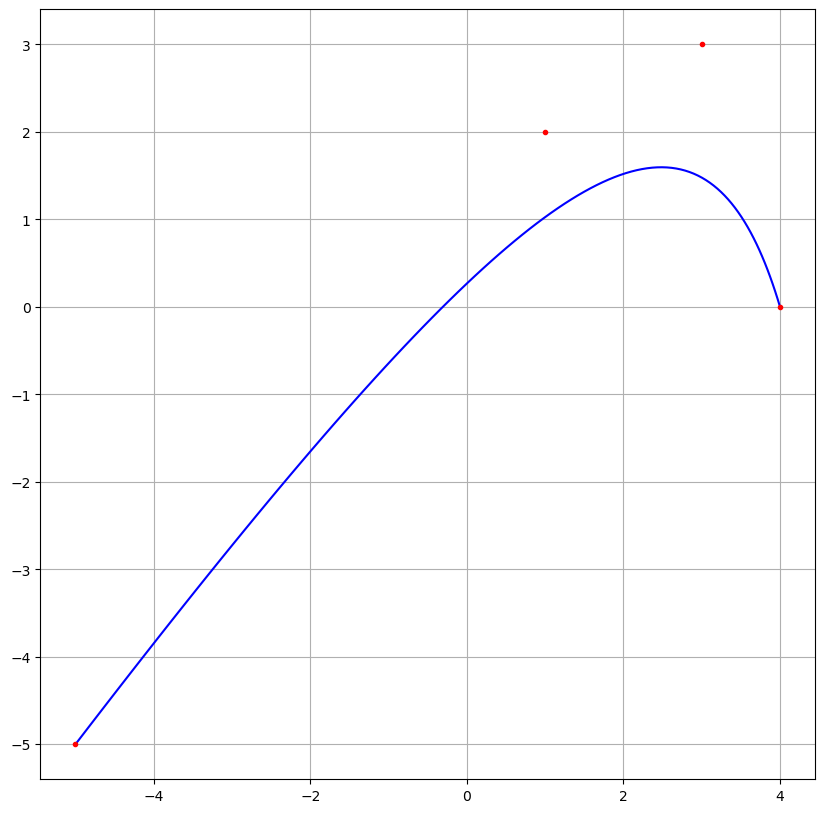

In [25]:
import numpy as np
from scipy.interpolate import BSpline

# 제어점 정의
control_points = np.array([(-5, -5), (1, 2), (3, 3), (4, 0)])

# B-spline의 차수 정의
k = 3

# Knots 벡터 정의 (여기서는 임의로 100개의 knots를 생성)
knots =np.concatenate( [[0]*k , np.linspace(0, 1, len(control_points)-1-k+2) , [1]*k])

# BSpline 객체 생성
spl = BSpline(knots, control_points, k)
# Generate points on the B-spline curve
t = np.linspace(0, 1, 100)
curve_points = spl(t)

plt.figure(figsize=(10, 10))
plt.plot(curve_points[:, 0], curve_points[:, 1], 'b-', label='B-Spline Curve')

plt.plot(control_points[:, 0], control_points[:, 1], 'r.')
plt.grid()



In [30]:
t, knots

(array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.72727273, 0.73

In [28]:
spl.c, spl.t, spl.k

(array([[-5., -5.],
        [ 1.,  2.],
        [ 3.,  3.],
        [ 4.,  0.]]),
 array([0., 0., 0., 0., 1., 1., 1., 1.]),
 3)

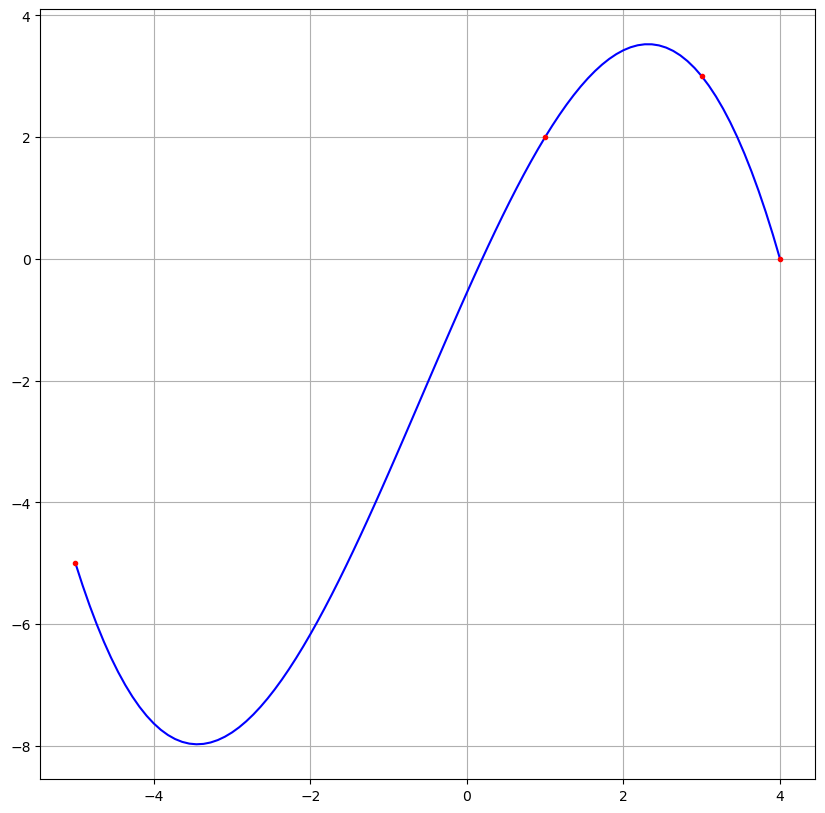

In [19]:
from scipy.interpolate import make_interp_spline

x = np.array([-5, 1, 3, 4])
y = np.array([-5, 2, 3, 0])

spline = make_interp_spline(x, y, k=3)

x_new = np.linspace(-5,4,100)
y_new = spline(x_new)

plt.figure(figsize=(10,10))
plt.plot(x_new, y_new, 'b')
plt.plot(x, y, 'r.')
plt.grid()

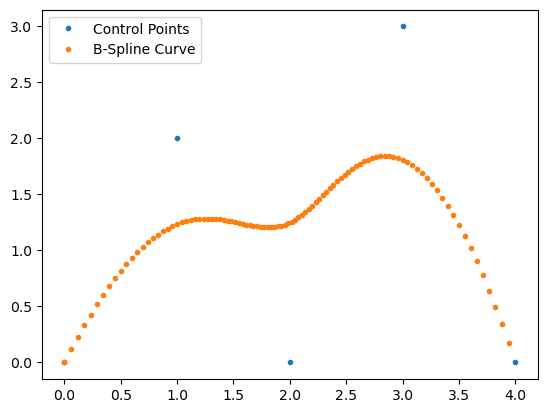

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 제어점 정의
control_points = np.array([
    [0.0, 0.0],
    [1.0, 2.0],
    [2.0, 0.0],
    [3.0, 3.0],
    [4.0, 0.0]
])

# 노드 벡터 정의
k = 3  # B-spline 차수
n = len(control_points)
t = np.concatenate(([0] * k, np.linspace(0, 1, n - k + 1), [1] * k))

# B-spline basis 함수 계산 (Cox-de Boor 점화식)
def b_spline_basis(i, k, t, t_val):
    if k == 0:
        return 1.0 if t[i] <= t_val < t[i + 1] else 0.0
    else:
        term1 = ((t_val - t[i]) / (t[i + k] - t[i])) * b_spline_basis(i, k - 1, t, t_val) if t[i + k] != t[i] else 0.0
        term2 = ((t[i + k + 1] - t_val) / (t[i + k + 1] - t[i + 1])) * b_spline_basis(i + 1, k - 1, t, t_val) if t[i + k + 1] != t[i + 1] else 0.0
        return term1 + term2

# t 값 범위 설정
t_vals = np.linspace(0, 1, 100)

# 미리 계산된 basis 값 저장
basis_values = np.zeros((len(t_vals), n))

for idx, t_val in enumerate(t_vals):
    for i in range(n):
        basis_values[idx, i] = b_spline_basis(i, k, t, t_val)

# B-spline 곡선 계산
spline_points = np.zeros((len(t_vals), 2))

for idx, t_val in enumerate(t_vals):
    for i in range(n):
        spline_points[idx] += basis_values[idx, i] * control_points[i]

# 결과 시각화
plt.plot(control_points[:, 0], control_points[:, 1], '.', label='Control Points')
plt.plot(spline_points[:, 0], spline_points[:, 1], '.',label='B-Spline Curve')
plt.legend()
plt.show()

Optimal t: 0.6313466580943479
Closest point on B-spline: [2.40310392 1.60156383]


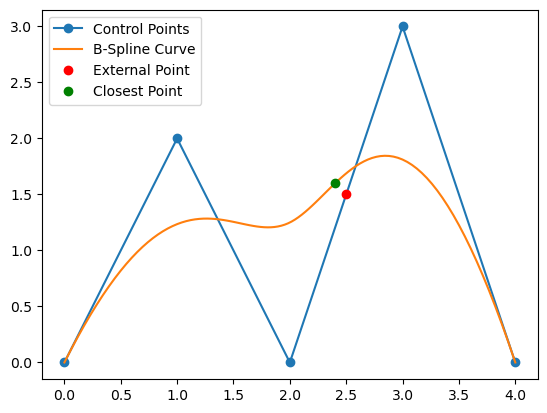

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.optimize import minimize

# 제어점 정의
control_points = np.array([
    [0.0, 0.0],
    [1.0, 2.0],
    [2.0, 0.0],
    [3.0, 3.0],
    [4.0, 0.0]
])

# 노드 벡터 정의
k = 3  # B-spline 차수
n = len(control_points)
t = np.concatenate(([0] * k, np.linspace(0, 1, n - k + 1), [1] * k))

# B-spline 객체 생성
spl = BSpline(t, control_points, k)

# 외부 점 정의
external_point = np.array([2.5, 1.5])

# 거리 함수 정의
def distance_function(t_val):
    spline_point = spl(t_val)
    return np.linalg.norm(spline_point - external_point)

# 최적화 문제 설정 및 해결
result = minimize(distance_function, x0=0.5, bounds=[(0, 1)])

# 최적의 t 값
optimal_t = result.x[0]

# B-spline 곡선 위의 가장 가까운 점
closest_point = spl(optimal_t)

# 결과 출력
print(f"Optimal t: {optimal_t}")
print(f"Closest point on B-spline: {closest_point}")

# 결과 시각화
t_vals = np.linspace(0, 1, 100)
spline_points = spl(t_vals)

plt.plot(control_points[:, 0], control_points[:, 1], 'o-', label='Control Points')
plt.plot(spline_points[:, 0], spline_points[:, 1], label='B-Spline Curve')
plt.plot(external_point[0], external_point[1], 'ro', label='External Point')
plt.plot(closest_point[0], closest_point[1], 'go', label='Closest Point')
plt.legend()
plt.show()

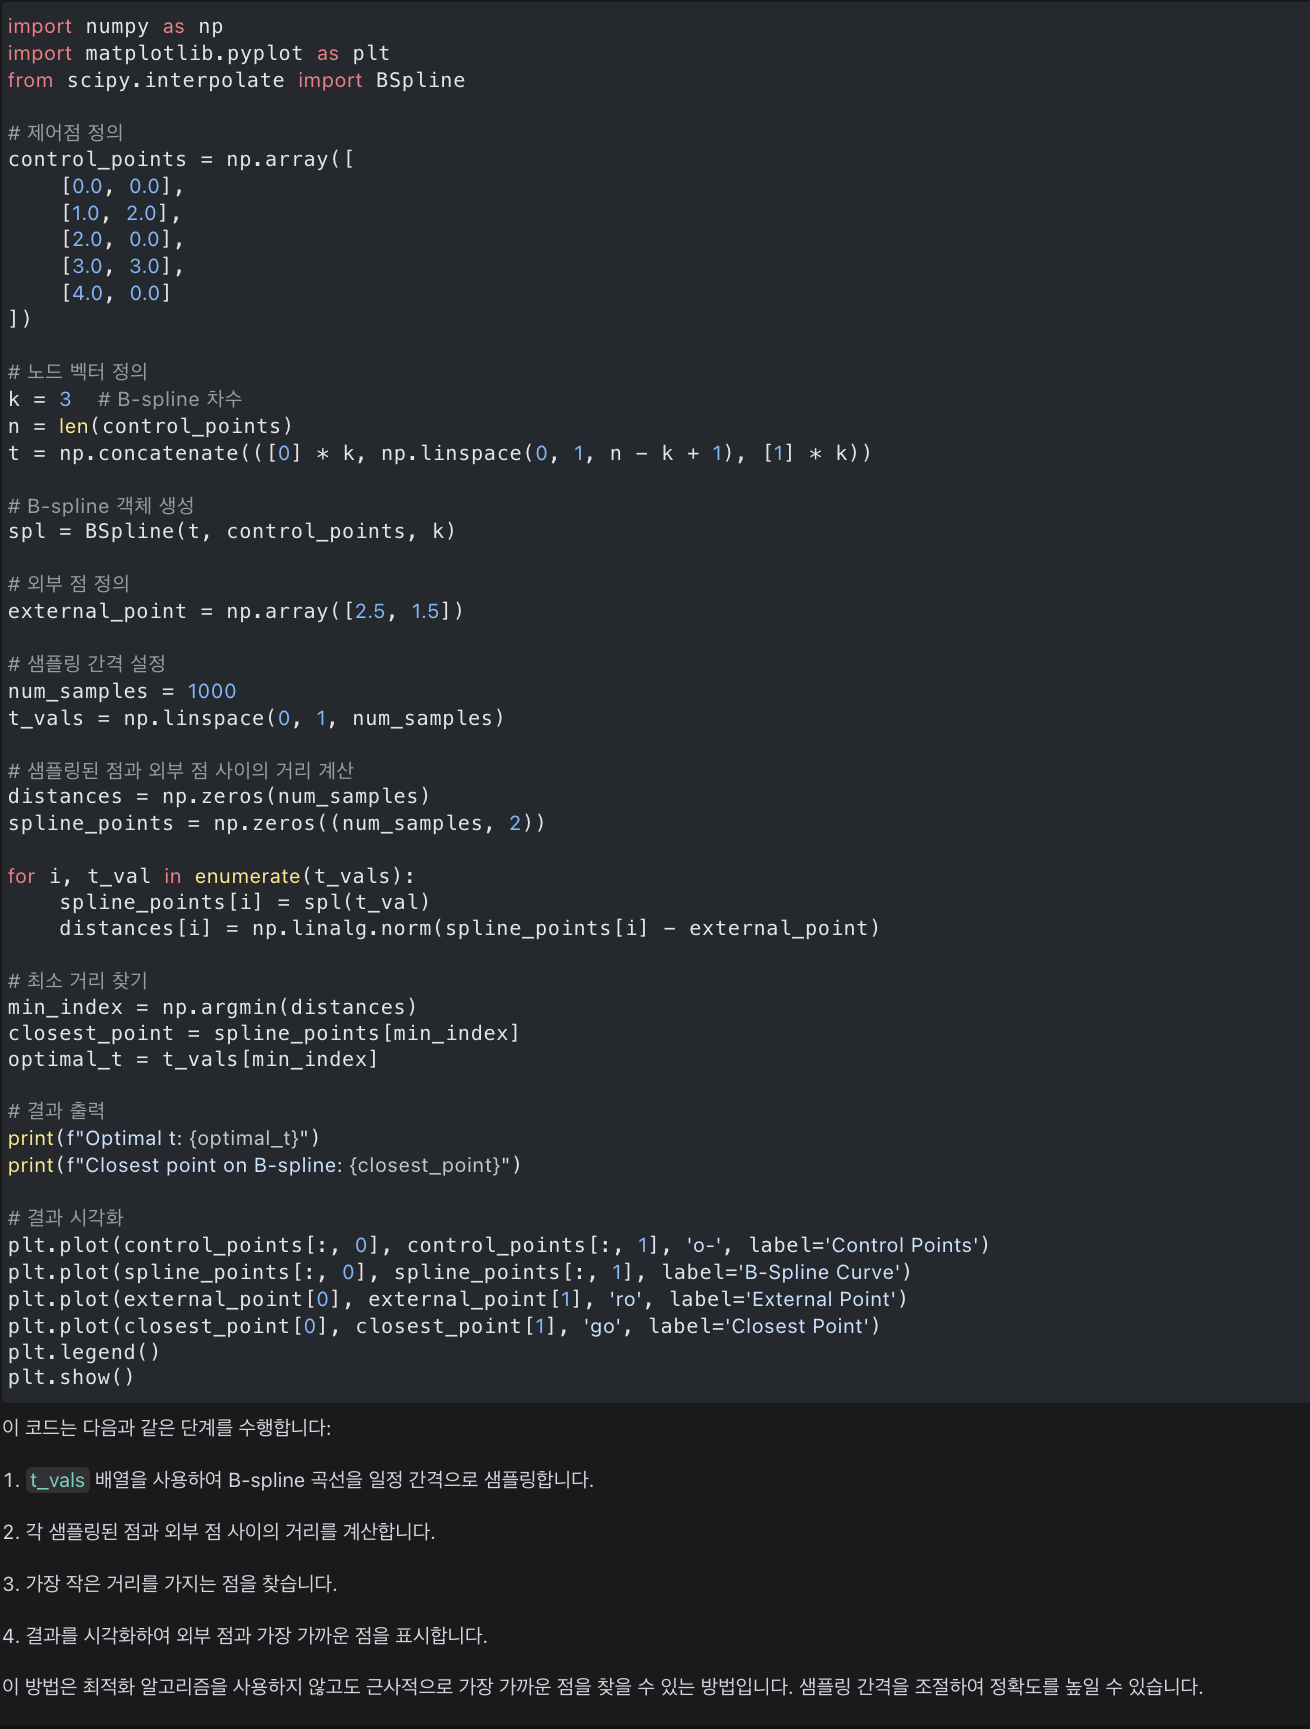